In [1]:
import os
import re
import numpy as np
import pandas as pd
import unicodedata
from wordcloud import WordCloud
import emoji
from emoji.unicode_codes import UNICODE_EMOJI

In [2]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
stop_words = stopwords.words('english')
stop_words.extend(['switzerland']) #'geneva','zurich','day','basel', ...

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [4]:
from time import time
import seaborn as sns
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter("ignore", DeprecationWarning)


In [5]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.summarization import keywords
from gensim.models import LdaModel

import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()


In [6]:
# from pyLDAvis import sklearn as sklearn_lda
# import pickle 
# import pyLDAvis

# # Load the LDA model from sk-learn
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation as LDA

Ref:

>[LDA gensim](https://radimrehurek.com/gensim/models/ldamodel.html)

>[NLTK raw text](http://www.nltk.org/book/ch03.html)



>[pyLDAvis]( https://pyldavis.readthedocs.io/en/latest/modules/API.html), [paper](https://www.aclweb.org/anthology/W14-3110.pdf)

>[Full emoji unicode list]( https://unicode.org/emoji/charts/full-emoji-list.html#1f60f)




# Pre-filter Relevant Attributes 
Or download <i><b>partial.csv</b></i> directly

In [6]:
file = 'complete_swiss_dataset.csv'
# use this block if you generate new dataset locally
full_data = pd.read_csv(file,engine='python',encoding='latin_1')
partial_data = full_data[['user_screen_name', 'latitude', 'longitude', 'text', 'lang', 'created_at_CET']]

# split datetime to date
test = partial_data['created_at_CET']
test = pd.DataFrame(test.str.split(' ', n = 1, expand = True)[0].tolist(), columns=['date'])
partial_data = pd.concat([partial_data, test], axis=1, sort=False)

# save partial data
partial_data.to_csv('partial.csv')

# Load Dataset

In [7]:
fn = 'partial.csv'
raw = pd.read_csv(fn, engine='python')
raw = raw.rename(columns={'Unnamed: 0': 'doc_no'}) # original tweet indices
raw = raw[raw.lang == 'en'] # keep English only
raw.head()
# raw.count() #420330

,doc_no,user_screen_name,latitude,longitude,text,lang,created_at_CET,date
0,0,________char,47.56231,7.592980,Cold toes in Switz <U+0001F1E8><U+0001F1ED> @ ...,en,2017-12-05 22:47:22,2017-12-05
3,3,_____FLOW_____,47.55831,7.587690,"I'm at @BaselTourism in Basel, Switzerland, Ba...",en,2015-06-27 12:47:23,2015-06-27
10,10,___ABAZA___,46.24492,6.230848,@cliffcheney depriving simple Egyptians from o...,en,2015-05-23 14:29:39,2015-05-23
16,16,___ABAZA___,46.24471,6.231037,Great initiative https://t.co/S8S6iHep1j\r\n#M...,en,2015-03-21 12:13:32,2015-03-21
20,20,___amaariee,47.57258,9.131390,Broken lights \r\nDriving backwards... \r\nMak...,en,2017-04-11 22:19:51,2017-04-11


In [10]:
# t1, t2 can be acquired from timeline given the granularity
t1 = '2016-06-01'
t2 = '2016-07-01'
papers = raw.loc[(raw['date']>=t1)& (raw['date']<t2)]


# Clean Text

In [11]:
# provide the duration of time, faster processing
# remove default text "Just posted a photo/video"
# remove links starting with "http(s)"
# translate unicode emojis to plain text

 
papers['text_processed'] = papers['text'].str.split("http", n = 1, expand = True)[0] 
# papers.count() #27487

# remove punctuations, normalize to lowercase, delete default text
papers['text_processed'] = papers['text_processed'].map(lambda x: re.sub('[,\.!?\@]', ' ', x))
papers['text_processed'] = papers['text_processed'].map(lambda x: re.sub('\r\n', ' ', x))
papers['text_processed'] = papers['text_processed'].map(lambda x: x.lower()) 
papers['text_processed'] = papers['text_processed'].str.replace('just posted a photo', '')
papers['text_processed'] = papers['text_processed'].str.replace('just posted a video', '')

# recognizable unicode format
papers['text_processed'] = papers['text_processed'].str.replace(r'<u\+',r'\\u') 
papers['text_processed'] = papers['text_processed'].str.replace('>','') 
papers['text_processed'] = papers['text_processed'].map(lambda x: re.sub("(?:u0001)|(?:u000e)", "U0001", x))

# demojize emoji unicode to text
papers['text_processed'] = papers['text_processed'].str.rstrip('\\') #remove distracting "\" at the end of strings
papers['text_processed'] = papers['text_processed'].map(lambda x: emoji.demojize(bytes(x,encoding='latin_1').decode('unicode_escape')))
papers['text_processed'] = papers['text_processed'].map(lambda x: re.sub('[:\#]', ' ', x)) #remove new ":" from demojize
papers['text_processed'] = papers['text_processed'].map(lambda x: x.lower()) 


<>:11: DeprecationWarning: invalid escape sequence \.
<>:25: DeprecationWarning: invalid escape sequence \#
<>:11: DeprecationWarning: invalid escape sequence \.
<>:25: DeprecationWarning: invalid escape sequence \#
<>:11: DeprecationWarning: invalid escape sequence \.
<>:25: DeprecationWarning: invalid escape sequence \#
<ipython-input-11-3078f803c165>:11: DeprecationWarning: invalid escape sequence \.
  papers['text_processed'] = papers['text_processed'].map(lambda x: re.sub('[,\.!?\@]', ' ', x))
<ipython-input-11-3078f803c165>:25: DeprecationWarning: invalid escape sequence \#
  papers['text_processed'] = papers['text_processed'].map(lambda x: re.sub('[:\#]', ' ', x)) #remove new ":" from demojize
/Users/zou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [32]:
papers['text_processed'].head(20)

480     life's worth living   sun    versoix (bord du ...
666     the same small lake near sion  (les îles de si...
702     ❂  camera  by  stevehadorn                 ⠀ ⠀...
754     ❂  camera  by   undderwolf                 ⠀ ⠀...
764     ❂  camera  by  thingthang                 ⠀ ⠀⠀...
804     ❂  camera  by   flovgram     ⠀⠀⠀⠀         ⠀ ⠀⠀...
870     ❂  camera  by   suisseounet                ⠀ ⠀...
1022    hope that soon the summer comes  it's rainy an...
1030    ❂  camera  by  sincerely chantal              ...
1092    ❂  camera  by  jonglr ⠀ ⠀⠀⠀⠀ ❂ location  greva...
1447    ⠀⠀⠀⠀⠀ ❂  camera  by  rafaelgraf_              ...
1474    lovely day at this nice place above  sietre in...
1518    ⠀⠀⠀⠀⠀ ❂  camera  by   marco_herzig            ...
1519    water reflection at small lake in sion  wish y...
1666    i love his voice so much  two_hearts   jetblac...
2301                         i'm at switzerland in basel 
2303                   i'm at mount titlis w/  dvana_dva 
2306    darien

In [13]:
# Tokenize to list
word_list = []
word_list += [word_tokenize(sentence) for sentence in list(papers['text_processed'].values)]

# remove stop words    
data_no_stop = [[word for word in line if word not in stop_words] for line in word_list]

# lemmatize and remove blank list
lemmatizer = WordNetLemmatizer() 
data_lemmatized = [[lemmatizer.lemmatize(word) for word in line if word.isalpha()]for line in data_no_stop]


# Wordcloud

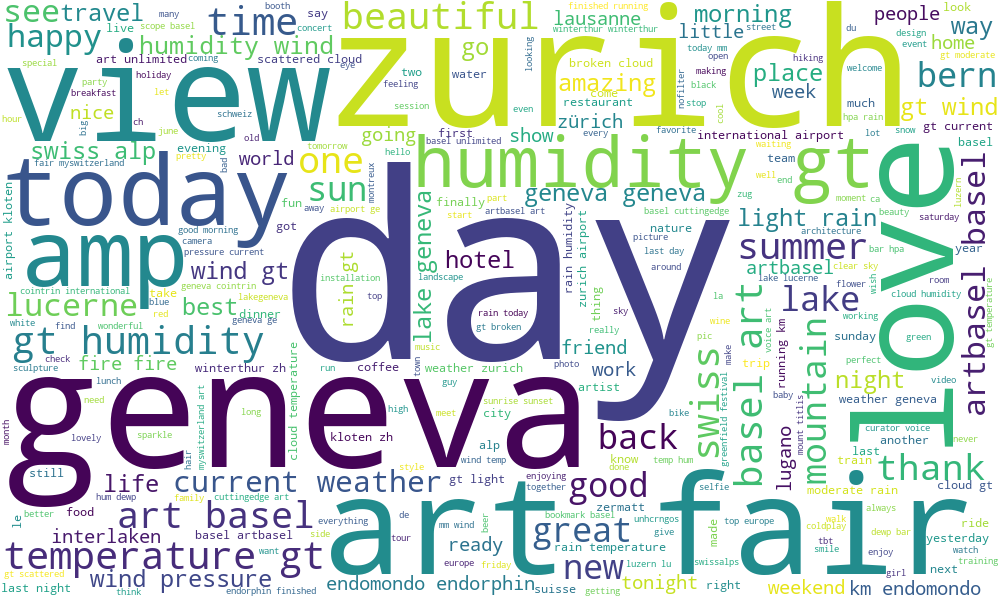

In [19]:
# Wordcloud visualization
# convert lists of words to a long string
input_str =','.join(','.join(row) for row in data_lemmatized)
wordcloud = WordCloud(background_color='white', width = 1000, height= 600, max_words=300, contour_width=3) 
wordcloud.generate(input_str)
wordcloud.to_image()

In [ ]:
# # Save word cloud pic 
# wordcloud.to_file('wordcloud.png')

# Gensim LDA

In [33]:
# Create the term dictionary, where every unique term is assigned an index. 
lda_path = './gensim_lda/'
dictionary = corpora.Dictionary(data_lemmatized)
dictionary.save(os.path.join(lda_path+'dictionary.dict'))


In [34]:
# Create a document-word matrix based on the dictionary
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]
corpora.MmCorpus.serialize(os.path.join(lda_path+'corpus.mm'), doc_term_matrix)

print (len(doc_term_matrix))
print (doc_term_matrix[100])

9643
[(95, 1), (202, 1), (203, 1), (205, 1), (207, 1), (208, 1), (209, 1), (210, 1)]


In [37]:
# desired topic numbers 
num_t = 20
model_name = lda_path+'topic'+str(num_t)+'.model'

In [39]:
# Apply LDA model with gensim
start = time()
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=num_t, id2word = dictionary, passes=50)
print ('used time: {:.2f}s'.format(time()-start))

ldamodel.save(model_name)

used time: 86.28s


In [41]:
# Print out topic no. and corresponding keywords, default num_words=10
for i in ldamodel.print_topics(num_words=20): 
    for j in i: 
        print (j)

0
0.047*"geneva" + 0.037*"international" + 0.037*"airport" + 0.034*"work" + 0.034*"ge" + 0.028*"festival" + 0.025*"another" + 0.021*"artunlimited" + 0.021*"greenfield" + 0.020*"next" + 0.017*"cointrin" + 0.014*"lounge" + 0.013*"vegan" + 0.013*"first" + 0.013*"best" + 0.013*"interlaken" + 0.012*"grand" + 0.012*"exhibition" + 0.011*"proud" + 0.010*"wedding"
1
0.051*"place" + 0.031*"interlaken" + 0.022*"food" + 0.017*"bad" + 0.016*"know" + 0.015*"find" + 0.015*"afternoon" + 0.015*"favorite" + 0.014*"brienz" + 0.013*"think" + 0.013*"perfect" + 0.012*"landscape" + 0.012*"one" + 0.012*"castle" + 0.011*"lakegeneva" + 0.010*"cat" + 0.010*"session" + 0.010*"rainbow" + 0.010*"beautiful" + 0.010*"italy"
2
0.054*"lausanne" + 0.029*"suisse" + 0.029*"km" + 0.028*"endorphin" + 0.028*"endomondo" + 0.025*"travel" + 0.025*"live" + 0.025*"finished" + 0.023*"tonight" + 0.020*"make" + 0.018*"coldplay" + 0.017*"lunch" + 0.016*"start" + 0.013*"b" + 0.013*"end" + 0.012*"waiting" + 0.011*"living" + 0.011*"letz

In [152]:
# # Load pervious parameters

# dictionary = gensim.corpora.Dictionary.load('dictionary.dict')
# doc_term_matrix = gensim.corpora.MmCorpus('corpus.mm') #doc_term_matrix
# ldamodel = gensim.models.LdaModel.load(model_name)

In [42]:
# Prepare for visualization 

data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.save_html(data,lda_path+'g_lda'+str(num_t)+'.html')
pyLDAvis.show(data)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [13/Aug/2020 16:38:43] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Aug/2020 16:38:43] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [13/Aug/2020 16:38:43] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Aug/2020 16:38:44] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Aug/2020 16:38:44] code 404, message Not Found
127.0.0.1 - - [13/Aug/2020 16:38:44] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


# Performance Metrics

In [43]:
from gensim.models import CoherenceModel

In [44]:
lda = gensim.models.LdaModel.load(model_name)
coherence_model_lda = CoherenceModel(model=lda, texts=data_lemmatized, dictionary=dictionary, coherence='c_v') 
#Coherence Score:  0.4430156773723783 (num_t=10, low)
#Coherence Score:  0.5086680966615635 (num_t=50, ok)
#Coherence Score:  0.5624528283697039 (30, fair)
coherence_lda = coherence_model_lda.get_coherence() 
print('\nCoherence Score: ', coherence_lda)
print('\nPerplexity: ', lda.log_perplexity(doc_term_matrix))


Coherence Score:  0.5372634432273683

Perplexity:  -13.9411030632686


# Find Dominant Topic

In [46]:
def dom_topic_per_doc(lda=ldamodel,dt_mat=doc_term_matrix):
    dominant_topic = []
    for i,line in enumerate(lda[dt_mat]): # for each tweet
        line = sorted(line, key=lambda x: (x[1]),reverse = True) #rank topic probabilities in descending order
        (topic_no, topic_prob) = line[0] #dominant topic with highest probability
        dominant_topic.append([int(topic_no), round(topic_prob,4)])
        dominant_topic_df = pd.DataFrame(dominant_topic,columns=['dom_topic','dom_prob'])
    return dominant_topic_df


In [48]:
x = dom_topic_per_doc(ldamodel, doc_term_matrix)
x.head()

,dom_topic,dom_prob
0,14,0.5611
1,7,0.3888
2,18,0.5087
3,18,0.5062
4,18,0.8643


In [50]:
papers.reset_index(drop=True,inplace=True)
papers.head()

,doc_no,user_screen_name,latitude,longitude,text,lang,created_at_CET,date,text_processed
0,480,__DVNT__,46.27706,6.169820,Life's worth living. <U+2600><U+FE0F> @ Versoi...,en,2016-06-23 22:20:34,2016-06-23,life's worth living sun versoix (bord du ...
1,666,__Gioja__,46.21311,7.333159,The same small lake near Sion. (les Îles de Si...,en,2016-06-04 09:04:07,2016-06-04,the same small lake near sion (les îles de si...
2,702,__Gioja__,47.21445,9.210276,<U+2742> <U+0001F4F7> by stevehadorn \...,en,2016-06-17 07:41:27,2016-06-17,❂ camera by stevehadorn ⠀ ⠀...
3,754,__Gioja__,46.42552,9.742871,<U+2742> <U+0001F4F7> by @undderwolf \...,en,2016-06-24 07:49:05,2016-06-24,❂ camera by undderwolf ⠀ ⠀...
4,764,__Gioja__,47.01670,8.650000,<U+2742> <U+0001F4F7> by thingthang \r...,en,2016-06-22 11:14:44,2016-06-22,❂ camera by thingthang ⠀ ⠀⠀...


In [51]:
papers = pd.concat([papers, x], axis=1)
papers.head()

,doc_no,user_screen_name,latitude,longitude,text,lang,created_at_CET,date,text_processed,dom_topic,dom_prob
0,480,__DVNT__,46.27706,6.169820,Life's worth living. <U+2600><U+FE0F> @ Versoi...,en,2016-06-23 22:20:34,2016-06-23,life's worth living sun versoix (bord du ...,14,0.5611
1,666,__Gioja__,46.21311,7.333159,The same small lake near Sion. (les Îles de Si...,en,2016-06-04 09:04:07,2016-06-04,the same small lake near sion (les îles de si...,7,0.3888
2,702,__Gioja__,47.21445,9.210276,<U+2742> <U+0001F4F7> by stevehadorn \...,en,2016-06-17 07:41:27,2016-06-17,❂ camera by stevehadorn ⠀ ⠀...,18,0.5087
3,754,__Gioja__,46.42552,9.742871,<U+2742> <U+0001F4F7> by @undderwolf \...,en,2016-06-24 07:49:05,2016-06-24,❂ camera by undderwolf ⠀ ⠀...,18,0.5062
4,764,__Gioja__,47.01670,8.650000,<U+2742> <U+0001F4F7> by thingthang \r...,en,2016-06-22 11:14:44,2016-06-22,❂ camera by thingthang ⠀ ⠀⠀...,18,0.8643


In [52]:
# papers.to_csv('topic_partial.csv')